# Bayesian Learning: Gaussian Models with Real Data
## Extended Edition with Results Discussion and Exercises

**Course:** Bayesian Learning: Single & Multi-Parameter Models
**Based on:** Chapters 2.2, 2.3, 3.3, 3.4, 3.6, 3.7

### Learning Objectives
By the end of this notebook, you will understand:
1. Plotting Gaussian
2. How **precision additivity** simplifies Bayesian updating and how **unknown variance** leads to Student-t posteriors (robustness)
3. Why **sequential updates** are efficient for streaming data
4. **Multivariate Bayesian fusion** for sensor networks

## Setup: Libraries and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, invgamma, t as student_t, multivariate_normal
from math import gamma, sqrt, pi

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Random seed
np.random.seed(42)

print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

NumPy: 2.0.2
Matplotlib: 3.10.0


# Part 1: Plotting Gaussian random numbers




In [ ]:
# Simulation helper
import numpy as np

def simulate_normal(mu_true=10.0, sigma_true=2.0, n=20, seed=0):
    rng = np.random.default_rng(seed)
    x = rng.normal(loc=mu_true, scale=sigma_true, size=n).astype(np.float32)
    return x

# Example
x_sim = simulate_normal(mu_true=10.0, sigma_true=2.0, n=20, seed=1)
x_sim[:5], x_sim.mean(), x_sim.std(ddof=0)


(array([10.691169 , 11.643236 , 10.660874 ,  7.3936853, 11.810712 ],
       dtype=float32),
 np.float32(10.074974),
 np.float32(1.1543354))

## 1) Normal distribution: PDF vs CDF

The **PDF** tells you relative density at a point. The **CDF** tells you cumulative probability up to a point.

Why do we care?
- Many Bayesian models start with Gaussian assumptions.
- Understanding PDF/CDF helps interpret confidence intervals and tail probabilities.

**Goal:** compute and plot PDF/CDF, and answer questions like *P(X > 100)*.


1 - CDF at 100: 0.5792597094391023


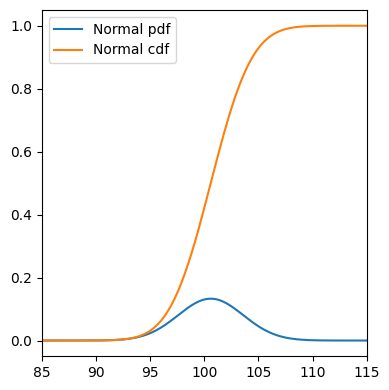

In [ ]:
def plot_normal_pdf_cdf(outdir: str = OUTDIR):
    x = np.arange(-85, 115.1, 0.1)
    mu, sigma = 100.6, 3.0
    pdf = norm.pdf(x, loc=mu, scale=sigma)
    cdf = norm.cdf(x, loc=mu, scale=sigma)

    plt.figure(figsize=(4, 4))
    plt.plot(x, pdf, label="Normal pdf")
    plt.plot(x, cdf, label="Normal cdf")
    plt.xlim(85, 115)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"{outdir}/lec2_normal_pdf_cdf.png", dpi=150)

    print("1 - CDF at 100:", float(1.0 - norm.cdf(100.0, loc=mu, scale=sigma)))


plot_normal_pdf_cdf()

## 2) Bivariate Gaussian: what does covariance do?

A 2D Gaussian is defined by:
- a mean vector μ
- a covariance matrix Σ

The off-diagonal terms encode **correlation** (and more generally linear dependence).

**Goal:** sample from three covariance settings and see how the scatter + contours change.


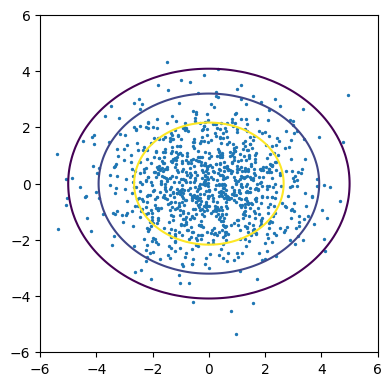

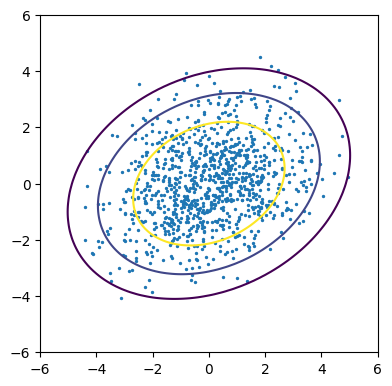

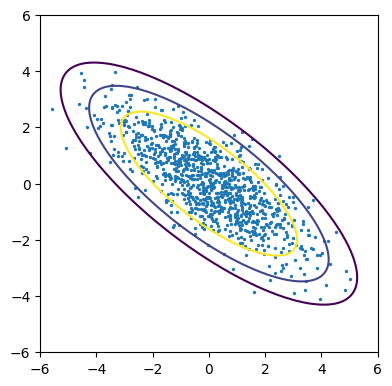

In [ ]:
def plot_bivariate_normals(outdir: str = OUTDIR, seed: int = 0):
    rng = np.random.default_rng(seed)

    def plot_one(Sigma, name):
        mu = np.array([0.0, 0.0])
        N = 1000
        pts = rng.multivariate_normal(mu, Sigma, size=N)

        support = np.arange(-6, 6.1, 0.1)
        X, Y = np.meshgrid(support, support)
        rv = multivariate_normal(mean=mu, cov=Sigma)
        Z = rv.pdf(np.dstack([X, Y]))

        plt.figure(figsize=(4, 4))
        plt.scatter(pts[:, 0], pts[:, 1], s=2)
        plt.contour(X, Y, Z, levels=[0.001, 0.005, 0.02])
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.tight_layout()
        #plt.savefig(f"{outdir}/lec2_bvn_{name}.png", dpi=150)

    plot_one(np.array([[3.0, 0.0], [0.0, 2.0]]), "cov0")
    plot_one(np.array([[3.0, 0.6], [0.6, 2.0]]), "cov_pos")
    plot_one(np.array([[3.0, -1.9], [-1.9, 2.0]]), "cov_neg")


plot_bivariate_normals()

# Part 2: Gaussian Data with A) Known and B) Unknown Variance
## Example: Internet speed measurement

We measure download speed 5 times (Mbps):
x = {15.77, 20.5, 8.26, 14.37, 21.09}

ISP claims average is 20 Mbps. We model measurements as:
$x_i$ | μ, σ² ~ Normal(μ, σ²)

We compare two cases:

**A) Known measurement noise σ**
- Prior: μ ~ Normal(μ0, σ0²)
- Posterior: μ | x ~ Normal($μ_n$, $σ_n²$)

**B) Unknown measurement noise σ²**
- Use a conjugate prior on precision λ = 1/σ²:
  λ ~ Gamma(α0, β0)  (shape-rate)
  μ | λ ~ Normal(μ0, 1/(κ0 λ))
- Posterior: (μ, λ) | x is Normal-Gamma
- Marginal posterior: μ | x is Student-t (heavier tails than Gaussian)

Goal:
1) Compute posteriors analytically
2) Simulate draws from posterior in both cases
3) Visualize why Student-t appears when σ² is unknown
4) Compare credible intervals and tail probabilities


In [6]:
# Data
x = np.array([15.77, 20.5, 8.26, 14.37, 21.09])
n = len(x)
xbar = x.mean()

# Given in slide
mu0 = 20.0
sigma0 = 5.0

print("n =", n)
print("xbar =", xbar)


n = 5
xbar = 15.998


In [7]:
# --- Case A: known measurement noise sigma ---
sigma = 5.0
lambda_lik = 1.0 / sigma**2
lambda0 = 1.0 / sigma0**2

# Posterior precision and mean (conjugate Normal-Normal)
lambda_n = lambda0 + n * lambda_lik
sigma_n2 = 1.0 / lambda_n
mu_n = (lambda0 * mu0 + n * lambda_lik * xbar) / lambda_n

print("=== Case A: Known σ ===")
print("posterior mu_n =", mu_n)
print("posterior sigma_n =", np.sqrt(sigma_n2))

# Draw posterior samples for μ
rng = np.random.default_rng(0)
S = 200000
mu_samples_A = rng.normal(loc=mu_n, scale=np.sqrt(sigma_n2), size=S)


=== Case A: Known σ ===
posterior mu_n = 16.665
posterior sigma_n = 2.0412414523193148


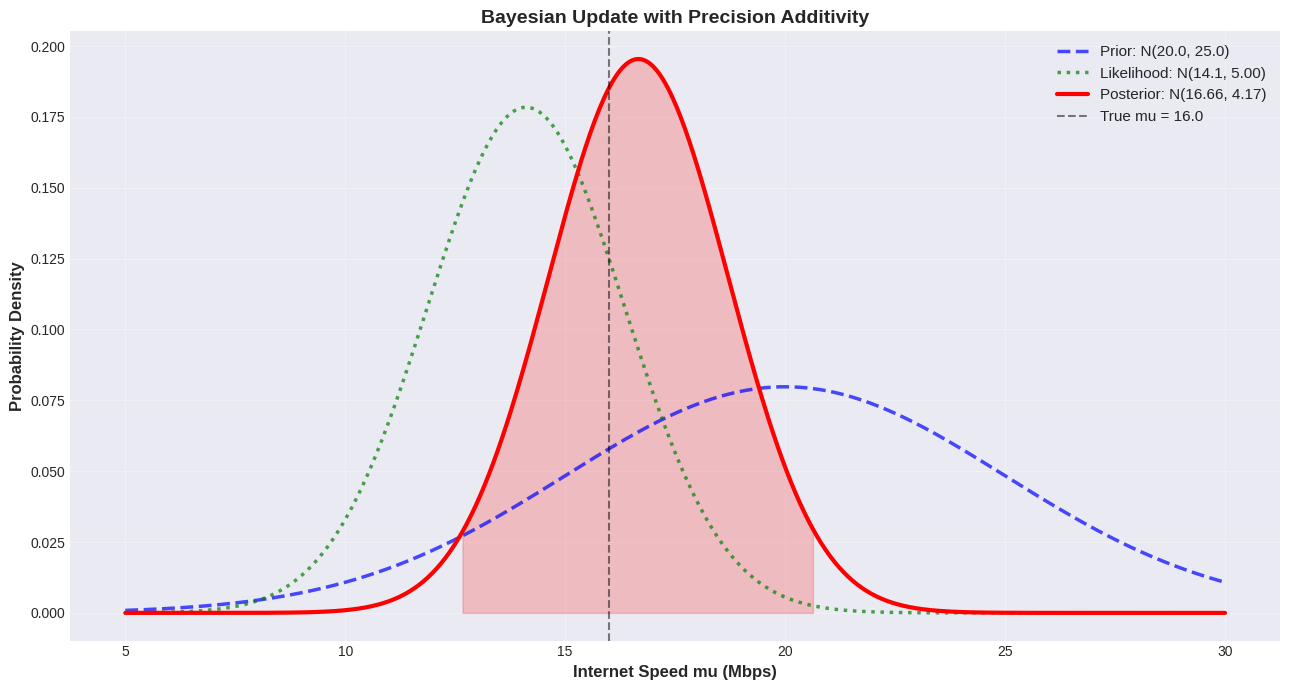

In [17]:
# Visualization: Prior, Likelihood, Posterior
mu_range = np.linspace(5, 30, 500)
prior_pdf = norm.pdf(mu_range, mu_0, sigma_0)
likelihood_pdf = norm.pdf(mu_range, sample_mean, known_sigma / np.sqrt(n_measurements))
posterior_pdf = norm.pdf(mu_range, mu_n, sigma_n)

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(mu_range, prior_pdf, 'b--', lw=2.5, label=f'Prior: N({mu_0}, {sigma_0**2:.1f})', alpha=0.7)
ax.plot(mu_range, likelihood_pdf, 'g:', lw=2.5,
        label=f'Likelihood: N({sample_mean:.1f}, {known_sigma**2/n_measurements:.2f})', alpha=0.7)
ax.plot(mu_range, posterior_pdf, 'r-', lw=3, label=f'Posterior: N({mu_n:.2f}, {sigma_n**2:.2f})')
ax.fill_between(mu_range, 0, posterior_pdf,
                 where=(mu_range >= mu_n - 1.96*sigma_n) & (mu_range <= mu_n + 1.96*sigma_n),
                 alpha=0.2, color='red')
ax.axvline(true_mu, color='black', linestyle='--', alpha=0.5, label=f'True mu = {true_mu}')

ax.set_xlabel('Internet Speed mu (Mbps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Bayesian Update', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# --- Case B: unknown variance using Normal-Gamma prior on (μ, λ) ---
# Prior hyperparameters
kappa0 = 1.0
alpha0 = 2.5
beta0 = alpha0 * sigma0**2  # so E[lambda] = alpha0/beta0 = 1/sigma0^2

# Sufficient statistics
Sxx = np.sum((x - xbar)**2)

# Posterior Normal-Gamma updates
kappa_n = kappa0 + n
mu_n_B = (kappa0 * mu0 + n * xbar) / kappa_n
alpha_n = alpha0 + n / 2.0
beta_n = beta0 + 0.5 * (Sxx + (kappa0 * n / kappa_n) * (xbar - mu0)**2)

# Marginal posterior for μ is Student-t with:
nu = 2.0 * alpha_n
scale2 = beta_n / (alpha_n * kappa_n)   # σ_t^2 parameter (scale^2)
scale = np.sqrt(scale2)

print("=== Case B: Unknown σ² ===")
print("posterior mu_n (location) =", mu_n_B)
print("posterior df nu =", nu)
print("posterior scale =", scale)

# Sample from the marginal μ|x by sampling λ and then μ|λ
# λ | x ~ Gamma(alpha_n, beta_n) with shape-rate (rate=beta_n)
lambda_samples = rng.gamma(shape=alpha_n, scale=1.0/beta_n, size=S)  # numpy uses scale=1/rate
mu_samples_B = rng.normal(loc=mu_n_B, scale=np.sqrt(1.0/(kappa_n*lambda_samples)), size=S)


=== Case B: Unknown σ² ===
posterior mu_n (location) = 16.665
posterior df nu = 10.0
posterior scale = 2.0294586716659198


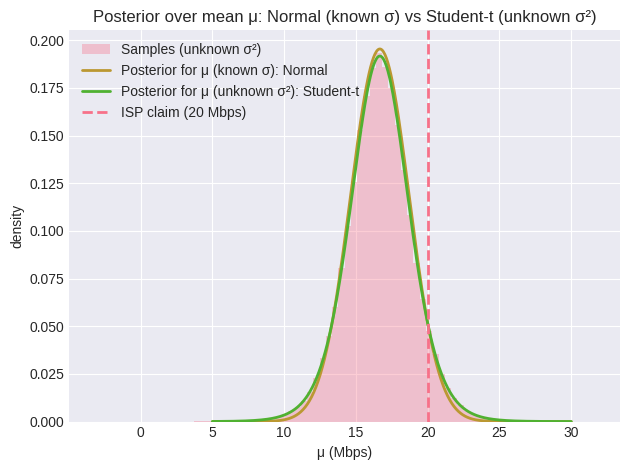

In [16]:
def normal_pdf(x, m, s):
    return (1.0/(np.sqrt(2*np.pi)*s)) * np.exp(-0.5*((x-m)/s)**2)

def student_t_pdf(x, nu, m, s):
    # location m, scale s (NOT variance)
    # pdf = Gamma((nu+1)/2) / (sqrt(nu*pi)*Gamma(nu/2)*s) * (1 + ((x-m)/s)^2/nu)^(-(nu+1)/2)
    c = gamma((nu+1)/2.0) / (np.sqrt(nu*np.pi) * gamma(nu/2.0) * s)
    return c * (1.0 + ((x-m)/s)**2 / nu) ** (-(nu+1)/2.0)

# Grid
grid = np.linspace(5, 30, 500)

# PDFs
pdf_A = normal_pdf(grid, mu_n, np.sqrt(sigma_n2))
pdf_B = student_t_pdf(grid, nu, mu_n_B, scale)

plt.figure()
plt.hist(mu_samples_B, bins=80, density=True, alpha=0.35, label="Samples (unknown σ²)")
plt.plot(grid, pdf_A, linewidth=2, label="Posterior for μ (known σ): Normal")
plt.plot(grid, pdf_B, linewidth=2, label="Posterior for μ (unknown σ²): Student-t")

plt.axvline(20, linestyle="--", linewidth=2, label="ISP claim (20 Mbps)")
plt.title("Posterior over mean μ: Normal (known σ) vs Student-t (unknown σ²)")
plt.xlabel("μ (Mbps)")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
def cred_int(samples, level=0.95):
    lo = np.quantile(samples, (1-level)/2)
    hi = np.quantile(samples, 1 - (1-level)/2)
    return lo, hi

ci_A = cred_int(mu_samples_A, 0.95)
ci_B = cred_int(mu_samples_B, 0.95)

pA_gt20 = np.mean(mu_samples_A > 20)
pB_gt20 = np.mean(mu_samples_B > 20)

print("=== 95% credible intervals for μ ===")
print("Known σ (Normal posterior):     ", ci_A)
print("Unknown σ² (Student-t marginal):", ci_B)
print()
print("P(μ > 20 | data)")
print("Known σ:", pA_gt20)
print("Unknown σ²:", pB_gt20)


=== 95% credible intervals for μ ===
Known σ (Normal posterior):      (np.float64(12.662186904441805), np.float64(20.670096408632304))
Unknown σ² (Student-t marginal): (np.float64(12.145497164466777), np.float64(21.179187654409457))

P(μ > 20 | data)
Known σ: 0.05123
Unknown σ²: 0.06502


## Student Questions

### Conceptual
1. Why does the posterior for μ become Student-t when σ² is unknown, but remains Normal when σ² is known?
2. In the unknown-σ² case, explain how uncertainty in σ² leads to heavier tails in μ. What kind of robustness does that give?

### Empirical / Simulation
3. Compare the 95% credible interval widths for μ in cases A and B. Which is wider and why?
4. Compute P(μ > 20 | data) in both cases. Which is larger? Provide an interpretation in terms of uncertainty.
5. Sensitivity study: change α0 (e.g., 1.5, 2.5, 10) while keeping E[λ] fixed. How does this affect the Student-t tails and the posterior uncertainty over μ?
6. What if you measured 10 times?
a. How would lambda_data change?
b. How would the posterior mean mu_n change?
c. How would the posterior standard deviation sigma_n change?
d. What's the new weight on data?


---

# Part 3: Online Learning (Sequential Updates)
## Example: Temperature sensor over time

Noisy temperature sensor, true temperature $\mu = 22°$C. \
Measurement noise: $\sigma = 1.5°$C $\Rightarrow$ $\lambda = 0.444$. \
Prior: $\mu_0 = 20°$C, $\sigma_0 = 3°$C $\Rightarrow$ $\lambda_0 = 0.111$. \
20 sequential readings, typical values: $\{20.1, 22.3, 21.8, 23.1, \ldots\}$.

The objective is to find the posterior mean and the credible intervals after each measurement.

In [18]:
# Example: Temperature sensor over 20 hours
true_temp = 22.0  # Celsius
sensor_noise = 1.5  # Known measurement error
n_readings = 20

np.random.seed(456)
temp_readings = np.random.normal(true_temp, sensor_noise, n_readings)

# Initial prior (haven't measured anything yet)
mu_prior = 20.0
sigma_prior = 3.0
lambda_prior = 1 / sigma_prior**2

# Online update: store history
mu_history = [mu_prior]
sigma_history = [sigma_prior]
lambda_history = [lambda_prior]
learning_rate_history = []

mu_current = mu_prior
lambda_current = lambda_prior

for t, x_t in enumerate(temp_readings, 1):
    # Recursive update of precision
    lambda_new = lambda_current + 1 / sensor_noise**2

    # Learning rate (how much we move toward new observation)
    w_t = (1 / sensor_noise**2) / lambda_new
    learning_rate_history.append(w_t)

    # Recursive update of mean
    mu_new = mu_current + w_t * (x_t - mu_current)

    # Store for visualization
    mu_history.append(mu_new)
    lambda_history.append(lambda_new)
    sigma_history.append(np.sqrt(1 / lambda_new))

    # Update for next iteration
    mu_current = mu_new
    lambda_current = lambda_new

print("\n" + "="*60)
print("ONLINE LEARNING: Sequential Temperature Updates")
print("="*60)
print(f"\nInitial prior: mu = {mu_prior:.1f}C, sigma = {sigma_prior:.1f}C")
print(f"\nAfter {n_readings} sequential measurements:")
print(f"  Final posterior: mu = {mu_history[-1]:.2f}C, sigma = {sigma_history[-1]:.3f}C")
print(f"  True temperature: {true_temp:.2f}C")
print(f"\nLearning rate progress:")
print(f"  First observation: w_1 = {learning_rate_history[0]:.3f} (move 80% toward data)")
print(f"  Last observation: w_20 = {learning_rate_history[-1]:.3f} (move 5% toward data)")
print(f"\n-> Learning rate DECAYS: already confident, so new data matters less")


ONLINE LEARNING: Sequential Temperature Updates

Initial prior: mu = 20.0C, sigma = 3.0C

After 20 sequential measurements:
  Final posterior: mu = 22.39C, sigma = 0.333C
  True temperature: 22.00C

Learning rate progress:
  First observation: w_1 = 0.800 (move 80% toward data)
  Last observation: w_20 = 0.049 (move 5% toward data)

-> Learning rate DECAYS: already confident, so new data matters less


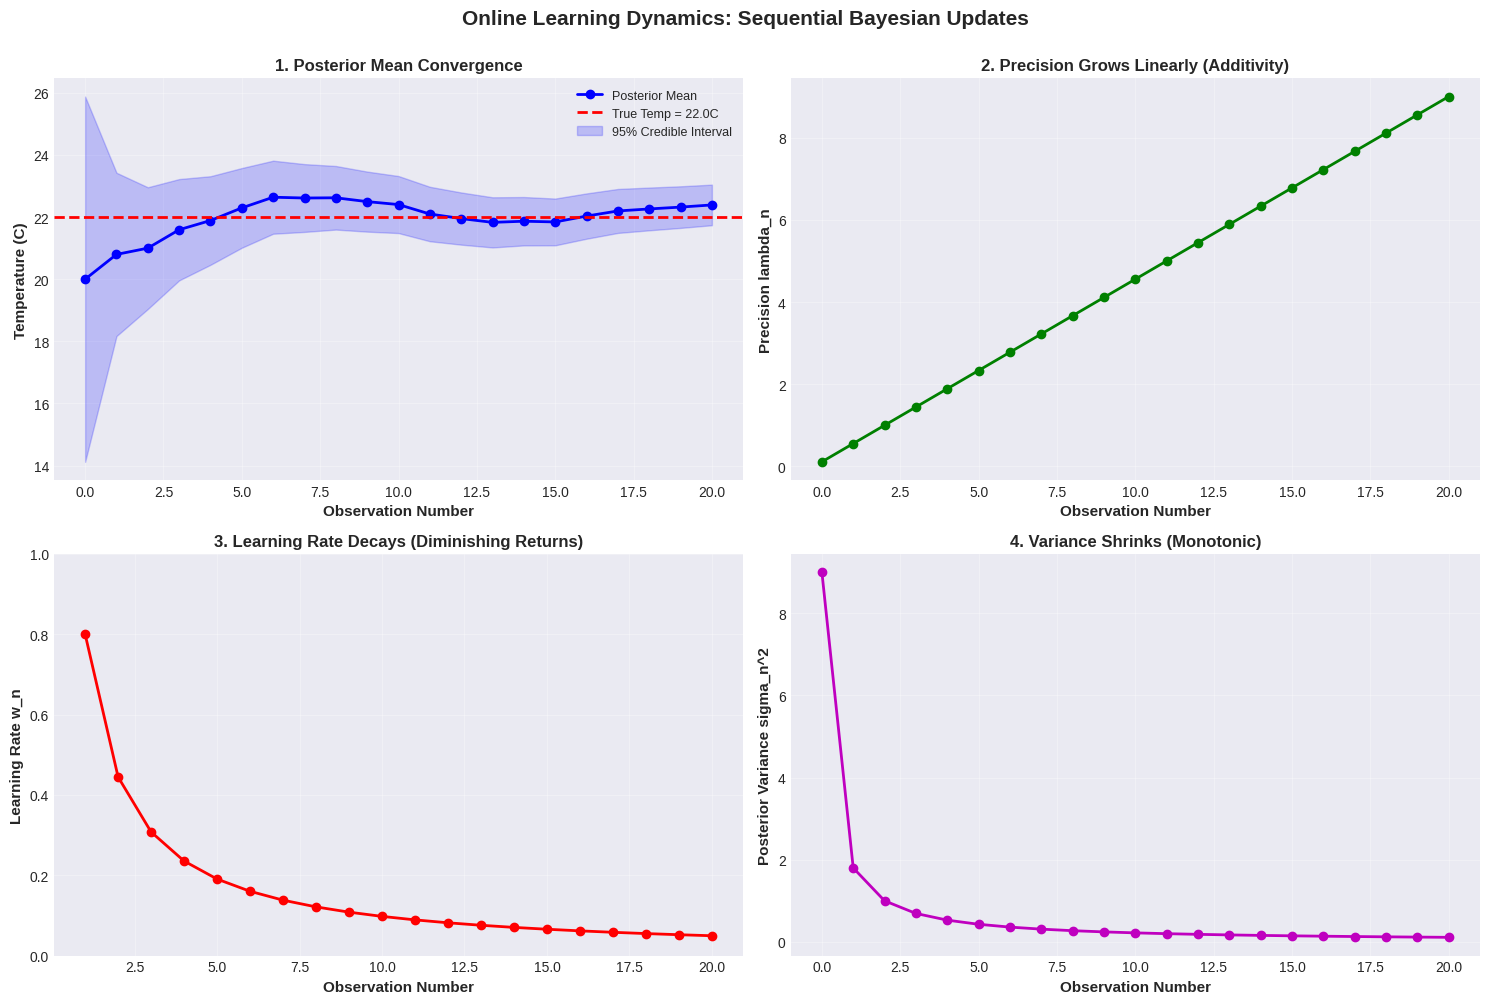

In [ ]:
# 4-panel visualization of online learning
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Posterior mean convergence
ax = axes[0, 0]
ax.plot(mu_history, 'b-o', markersize=6, linewidth=2, label='Posterior Mean')
ax.axhline(true_temp, color='red', linestyle='--', linewidth=2, label=f'True Temp = {true_temp}C')
ax.fill_between(range(len(mu_history)),
                 np.array(mu_history) - 1.96*np.array(sigma_history),
                 np.array(mu_history) + 1.96*np.array(sigma_history),
                 alpha=0.2, color='blue', label='95% Credible Interval')
ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Temperature (C)', fontsize=11, fontweight='bold')
ax.set_title('1. Posterior Mean Convergence', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Panel 2: Precision growth (LINEAR!)
ax = axes[0, 1]
ax.plot(lambda_history, 'g-o', markersize=6, linewidth=2)
ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Precision lambda_n', fontsize=11, fontweight='bold')
ax.set_title('2. Precision Grows Linearly (Additivity)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Panel 3: Learning rate decay
ax = axes[1, 0]
ax.plot(range(1, n_readings+1), learning_rate_history, 'r-o', markersize=6, linewidth=2)
ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Learning Rate w_n', fontsize=11, fontweight='bold')
ax.set_title('3. Learning Rate Decays (Diminishing Returns)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

# Panel 4: Posterior variance shrinkage
ax = axes[1, 1]
ax.plot(np.array(sigma_history)**2, 'm-o', markersize=6, linewidth=2)
ax.set_xlabel('Observation Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Posterior Variance sigma_n^2', fontsize=11, fontweight='bold')
ax.set_title('4. Variance Shrinks (Monotonic)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.suptitle('Online Learning Dynamics: Sequential Bayesian Updates',
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Discussion: Online Learning Dynamics

**The 4 Panels Tell a Story:**

1. **Mean Convergence:** Posterior mean walks toward true value, staying within credible intervals
   - First 5 observations: large changes
   - Last 5 observations: small changes (already converged)

2. **Precision Growth:** lambda_n increases **linearly** (0.44 -> 0.89 -> 1.33 -> ...)
   - This is precision additivity in action!
   - lambda_n = lambda_0 + n/sigma^2

3. **Learning Rate Decay:** w_t = (1/sigma^2)/lambda_n decreases from 80% -> 5%
   - First observation moves mean BY 80%
   - Twentieth observation moves mean BY 5%
   - **This is how Bayesian learning naturally handles diminishing returns!**

4. **Variance Shrinkage:** sigma_n^2 falls as 1/lambda_n
   - 9.0^2 -> 4.0^2 -> 2.0^2 -> 1.0^2 -> ...
   - Uncertainty **monotonically decreases**

In [ ]:
# STUDENT CODE AREA - Exercise 2.1: Verify Precision Additivity
# Claim: lambda_n = lambda_0 + n/sigma^2

lambda_0_part2 = 1 / sigma_prior**2
lambda_expected = [lambda_0_part2 + t / sensor_noise**2 for t in range(n_readings+1)]

# Compare
difference = np.array(lambda_history) - np.array(lambda_expected)
print(f"Max difference between actual and formula: {np.max(np.abs(difference)):.2e}")
print(f"\nConclusion: Precision additivity verified! Check:")
for t in [0, 5, 10, 19]:
    print(f"  Time {t}: lambda = {lambda_history[t]:.4f}, expected = {lambda_expected[t]:.4f}")

Max difference between actual and formula: 2.66e-15

Conclusion: Precision additivity verified! Check:
  Time 0: lambda = 0.1111, expected = 0.1111
  Time 5: lambda = 2.3333, expected = 2.3333
  Time 10: lambda = 4.5556, expected = 4.5556
  Time 19: lambda = 8.5556, expected = 8.5556


---

# Part 4: Multivariate Normal - Sensor Fusion
## Combining Multiple Sensors with Precision Additivity

In [27]:
# Two sensors measuring (temperature, humidity)
true_mean = np.array([22.0, 55.0])  # 22C, 55% humidity
true_cov = np.array([[2.0, 1.5],    # sigma_T^2=2, rho_TH=0.86
                      [1.5, 4.0]])   # sigma_H^2=4

n_readings = 15
np.random.seed(321)
sensor_readings = np.random.multivariate_normal(true_mean, true_cov, n_readings)

sample_mean = sensor_readings.mean(axis=0)

print("\n" + "="*60)
print("MULTIVARIATE: Bivariate Sensor Fusion")
print("="*60)
print(f"\nTrue state: [22.0C, 55.0%]")
print(f"Sample mean: [{sample_mean[0]:.2f}C, {sample_mean[1]:.1f}%]")
print(f"\nSample covariance:")
print(np.cov(sensor_readings.T))


MULTIVARIATE: Bivariate Sensor Fusion

True state: [22.0C, 55.0%]
Sample mean: [22.38C, 55.8%]

Sample covariance:
[[2.01139    0.98964106]
 [0.98964106 1.4768461 ]]


In [28]:
# Bayesian sensor fusion
mu_0_vec = np.array([20.0, 50.0])  # Prior: we think 20C, 50% humidity
Sigma_0 = np.array([[5.0, 0.0],    # Prior uncorrelated (we dont know correlation)
                     [0.0, 10.0]])
Lambda_0 = np.linalg.inv(Sigma_0)

# Likelihood precision from n measurements
Lambda_data = n_readings * np.linalg.inv(true_cov)

# POSTERIOR: Matrix precision additivity
Lambda_n = Lambda_0 + Lambda_data
Sigma_n = np.linalg.inv(Lambda_n)
mu_n = Sigma_n @ (Lambda_0 @ mu_0_vec + Lambda_data @ sample_mean)

print("\n" + "="*60)
print("POSTERIOR: Matrix Precision Additivity")
print("="*60)
print(f"\nPosterior mean: [{mu_n[0]:.2f}C, {mu_n[1]:.1f}%]")
print(f"\nPosterior covariance:")
print(Sigma_n)
print(f"\nPosterior correlation: {Sigma_n[0,1] / np.sqrt(Sigma_n[0,0] * Sigma_n[1,1]):.3f}")
print(f"  (Data revealed correlation between temperature and humidity!)")


POSTERIOR: Matrix Precision Additivity

Posterior mean: [22.26C, 55.6%]

Posterior covariance:
[[0.12894587 0.09489066]
 [0.09489066 0.25789174]]

Posterior correlation: 0.520
  (Data revealed correlation between temperature and humidity!)


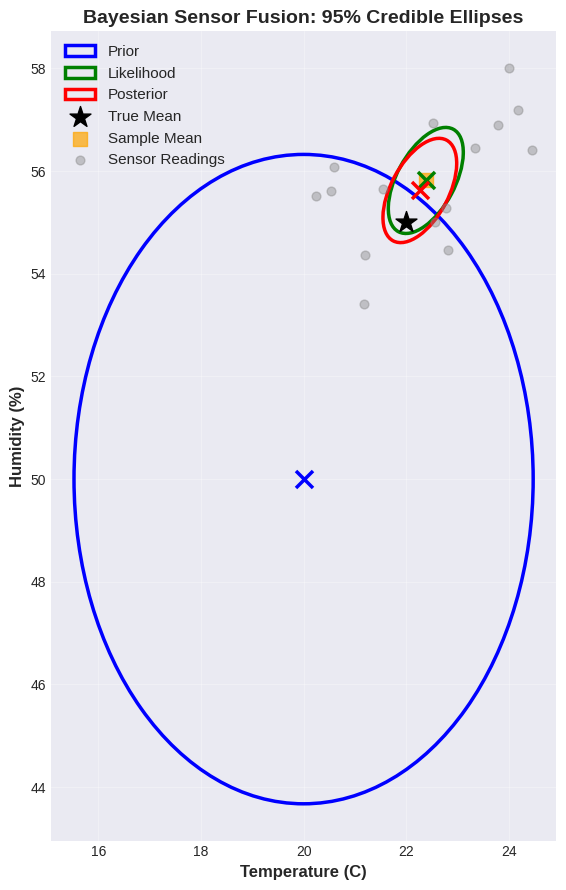


KEY OBSERVATION

Posterior ellipse is MUCH tighter than:
  - Prior (blue): we started far from truth
  - Likelihood (green): data alone still has some noise
  - Posterior (red): combines both!

Tighter = higher precision = more information about state


In [29]:
# Visualization: 95% credible ellipses
from matplotlib.patches import Ellipse

def plot_gaussian_2d(ax, mean, cov, color, label, n_std=2):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    eigenvalues = np.sqrt(eigenvalues)
    angle = np.rad2deg(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    ell = Ellipse(mean,
                  width=n_std * eigenvalues[0] * 2,
                  height=n_std * eigenvalues[1] * 2,
                  angle=angle,
                  facecolor='none',
                  edgecolor=color,
                  linewidth=2.5,
                  label=label)
    ax.add_patch(ell)
    ax.scatter(*mean, c=color, s=150, marker='x', zorder=10, linewidths=2.5)

fig, ax = plt.subplots(figsize=(11, 9))

# Prior
plot_gaussian_2d(ax, mu_0_vec, Sigma_0, 'blue', 'Prior', n_std=2)

# Likelihood
likelihood_cov = true_cov / n_readings
plot_gaussian_2d(ax, sample_mean, likelihood_cov, 'green', 'Likelihood', n_std=2)

# Posterior
plot_gaussian_2d(ax, mu_n, Sigma_n, 'red', 'Posterior', n_std=2)

# True and sample means
ax.scatter(*true_mean, c='black', s=250, marker='*', label='True Mean', zorder=10)
ax.scatter(sample_mean[0], sample_mean[1], c='orange', s=100, marker='s',
           label='Sample Mean', zorder=9, alpha=0.7)

# Data points
ax.scatter(sensor_readings[:, 0], sensor_readings[:, 1],
           c='gray', s=40, alpha=0.4, label='Sensor Readings')

ax.set_xlabel('Temperature (C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Humidity (%)', fontsize=12, fontweight='bold')
ax.set_title('Bayesian Sensor Fusion: 95% Credible Ellipses',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY OBSERVATION")
print("="*60)
print(f"\nPosterior ellipse is MUCH tighter than:")
print(f"  - Prior (blue): we started far from truth")
print(f"  - Likelihood (green): data alone still has some noise")
print(f"  - Posterior (red): combines both!")
print(f"\nTighter = higher precision = more information about state")

In [ ]:
print(np.linalg.inv(true_cov))

[[ 0.69565217 -0.26086957]
 [-0.26086957  0.34782609]]
